In [1]:
# !pip install mvlearn==0.5.0 wordcloud==1.9.3 matplotlib==3.3.4 distinctipy==1.3.4 networkx==3.2.1  umap==0.1.1 hoggorm==0.13.3 adilsm==0.0.11 scikit-learn==1.1.2 scipy==1.9.1 numpy==1.23.3
# scipy==1.9.1 used (due to changes in SVDS in later versions) to reproduce presented results in ref paper
# scikit-learn==1.1.2 used (due to changes in MDS in later versions) to reproduce presented results in ref paper
# numpy==1.23.3 used (due to changes in ??? in later versions) to reproduce presented results in ref paper

In [2]:
# !pip install -e ..
# !pip list
# ! pip show scipy

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import distinctipy
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.preprocessing import normalize
from mvlearn.datasets import load_UCImultifeature

from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score

import adilsm.adilsm as ilsm
from ism_utils import specificity_score, specificity_plot

RESULTS_PATH = '../results/'
DATA_PATH = '../data/'

adilsm version=0.0.13


Data prep

In [2]:
###############################################################################
# Load Data
# ---------
# Data comes from UCI Digits Data. Contains 6 views and classifications of
# numbers 0-9

Xs, list_digits = load_UCImultifeature()

sample_rate = 1

if sample_rate < 1:
    num_rows = list_digits.shape[0]
    num_rows_to_select = int(num_rows * sample_rate)
    selected_rows = np.random.choice(num_rows, num_rows_to_select, replace=False)

    for i in range(len(Xs)):
        Xs[i] = Xs[i][selected_rows]

    list_digits = list_digits[selected_rows]

list_cell_codes, list_cell_types = pd.factorize(list_digits)

# Check data
print(f'There are {len(Xs)} views.')
print(f'There are {Xs[0].shape[0]} observations')
print(f'The feature sizes are: {[X.shape[1] for X in Xs]}')


There are 6 views.
There are 2000 observations
The feature sizes are: [76, 216, 64, 240, 47, 6]


In [3]:
Xs_ism = [None] * 7
Xs_ism[0] = Xs[0].copy()
Xs_ism[1] = Xs[1].copy()

Xs_ism[2] = Xs[2].copy()
Xs_ism[2][Xs_ism[2]<0] = 0

Xs_ism[3] = -Xs[2].copy()
Xs_ism[3][Xs_ism[3]<0] = 0

for i in range(4,len(Xs_ism)):
    Xs_ism[i] = Xs[i-1].copy()


ISM workflow

In [4]:
n_embedding, n_themes = [9,10]

ilsm_result = ilsm.ism(Xs_ism, n_embedding, n_themes, norm_columns=1, update_h_ism=True,
                                    max_iter_mult=200, fast_mult_rules=True, sparsity_coeff=.8)
hv = ilsm_result['HV']
hv_sparse = ilsm_result['HV_SPARSE']
hhii_updated = ilsm_result['HHII']
w4_ism = ilsm_result['W']
h4_ism = ilsm_result['H']
q4_ism = ilsm_result['Q']
Xs_emb = ilsm_result['EMBEDDING']
Xs_norm = ilsm_result['NORMED_VIEWS']

h4_updated_sparse = hv[0].copy()
for h in hv_sparse[1:]:
    h4_updated_sparse = np.vstack((h4_updated_sparse, h))

print('condition number('+str(n_embedding)+', '+str(n_themes)+') = ', np.round(np.linalg.cond(h4_updated_sparse), 2))


error ism before straightening:  0.39
Straightening:
iteration 0...
iteration 1...
iteration 2...
iteration 3...
iteration 4...
iteration 5...
iteration 6...
iteration 7...
iteration 8...
iteration 9...
iteration 10...
iteration 11...
iteration 12...
iteration 13...
iteration 14...
iteration 15...
iteration 16...
iteration 17...
iteration 18...
iteration 19...
error ism after straightening:  0.52
condition number(9, 10) =  7.62


Figures

In [5]:
# 16-16 with .8
# generate N visually distinct colours

# MDS projection
mds = MDS(n_components=2, random_state=0)
# mds = umap.UMAP(random_state=0, n_jobs=1, min_dist=1)

n_marker_genes = list_cell_codes.shape[0]

stress = []

w4_ism_mds = mds.fit_transform(normalize(w4_ism[:n_marker_genes,:], axis=0, norm='l2'))
stress.append(mds.stress_)

print(stress)

[491.4730131240673]


10 5.81
0.5743
0.6667


<function matplotlib.pyplot.show(close=None, block=None)>

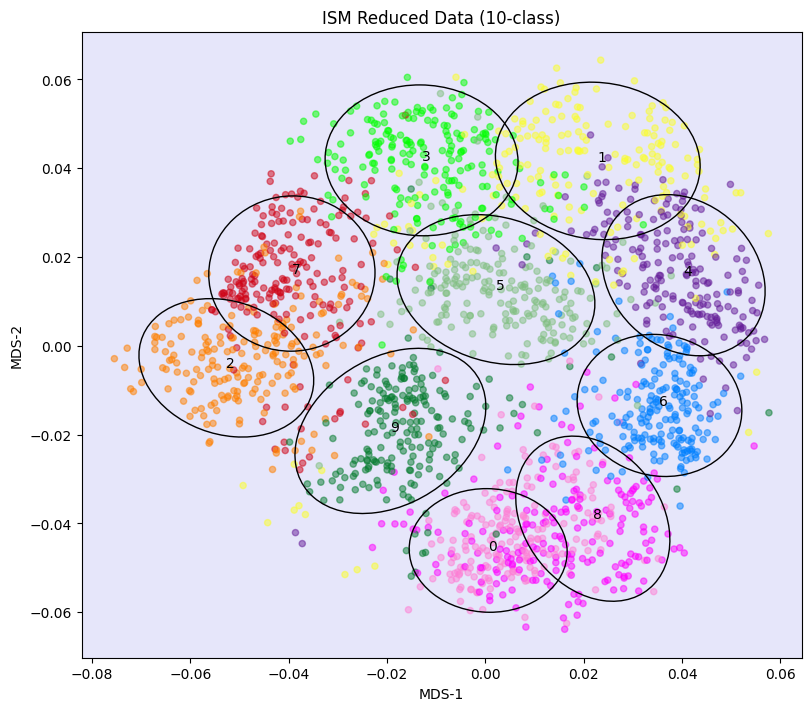

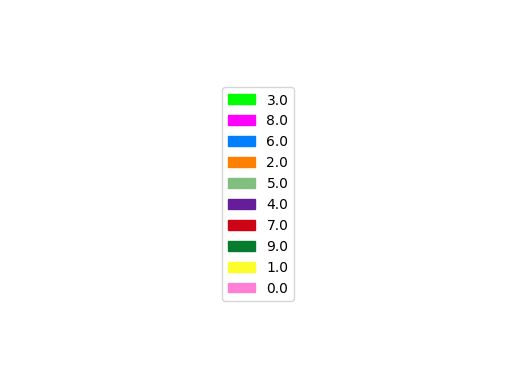

In [6]:
palette = distinctipy.get_colors(10)
cmap = ListedColormap(palette)

patches = []
for code in range(10):
    patches.append(mpatches.Patch(color=palette[code], label=list_cell_types[code]))

# Define a function to plot the confidence ellipse
def confidence_ellipse(x, y, cell_label, ax, n_std=2, facecolor='none', **kwargs):
    # Create a plot of the covariance confidence ellipse of `x` and `y`
    # Adapted from [1](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html)
    
    # Calculate the covariance matrix and the Pearson correlation coefficient
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Use a special case to obtain the eigenvalues of the covariance matrix
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    
    # Create the ellipse object
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    
    # Scale and translate the ellipse according to the mean and standard deviation of the data
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    
    # Annotate centroid
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    ax.annotate(int(cell_label), xy=(x_mean, y_mean))

    # Add the ellipse to the axes
    ax.add_patch(ellipse)
    return x_mean, y_mean

# define a function to plot scatter with clusters and confidence ellipses
def plot_scatter(x, y, title=None, k=None, ax=None, list_cell_codes=None, skip_ellipse=[], face_color='lavender', **kwargs):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(np.c_[x, y])
    # Get the cluster labels and centroids
    labels = kmeans.labels_  # Get cluster labels
    labels_matched = np.empty_like(labels)
    unique_labels = np.unique(labels)
    truth_label = np.zeros(len(unique_labels))

    # For each cluster label...
    for l in unique_labels:
        # ...find and assign the best-matching truth label
        match_nums = [np.sum((labels==l)*(list_cell_codes==t)) for t in np.unique(list_cell_codes)]
        truth_label[l] = np.unique(list_cell_codes)[np.argmax(match_nums)]
        labels_matched[labels==l] = truth_label[l]

    ax.scatter(x, y, c=list_cell_codes[:n_marker_genes], cmap=cmap, alpha=0.5, s=20)
    ax.set_title(title)
    ax.set_xlabel("MDS-1")
    ax.set_ylabel("MDS-2")
    ax.set_facecolor(face_color)

    p1 = np.zeros(k)
    p2 = np.zeros(k)
    unique_labels_matched = np.unique(labels_matched)
    xy_mean = np.zeros((len(unique_labels),2))    
    mean_intra_distance = np.zeros(len(unique_labels))
    mean_inter_distance = np.zeros(len(unique_labels))
    flag = np.zeros(len(unique_labels))

    for l in unique_labels_matched:
        indices = np.where(truth_label == l)[0]
        if indices.shape[0] > 1:
            # calculate mean distance inter-clusters pointing to same class
            xy_mean2 = np.zeros((indices.shape[0],2))
            for l2 in range(len(indices)):
                xy_mean2[l2,0] = np.mean(x[labels == indices[l2]])
                xy_mean2[l2,1] = np.mean(y[labels == indices[l2]])
                xy_intra = np.column_stack((x[labels == indices[l2]], y[labels == indices[l2]]))
                D = distance_matrix(xy_intra, xy_intra)
                mean_intra_distance[l] += np.mean(D[D>0])
                    
            D = distance_matrix(xy_mean2, xy_mean2)
            mean_inter_distance[l] = np.mean(D[D>0])
            if mean_inter_distance[l] / mean_intra_distance[l] > 1:
                flag[l] = 1

    n_matched_cell_types = 0
    
    for l in np.unique(labels_matched):
        if not flag[l]:
            p1[l] = np.sum(labels_matched[labels_matched==l] == list_cell_codes[labels_matched==l])
            p2[l] = p1[l] / np.sum(list_cell_codes == l)
            p1[l] /=  np.sum(labels_matched == l)
            if p2[l] > .5:
                n_matched_cell_types += 1
                xy_mean[l,0], xy_mean[l,1] = confidence_ellipse(x[labels_matched == l], y[labels_matched == l], list_cell_types[l], ax, n_std=2, edgecolor='black')
            else:
                p1[l] = 0
                p2[l] = 0
        else:
            xy_mean[l,0] = 0
            xy_mean[l,1] = 0
    
    inter_distance = distance_matrix(xy_mean, xy_mean)
    mean_inter_distance = np.mean(inter_distance[inter_distance>0])
    norm_distance = np.max(inter_distance) - inter_distance
    # print(p1)
    # print(p2)
    print(n_matched_cell_types, round(np.sum(p1*p2),2))
    print(round(adjusted_rand_score(labels_matched, list_cell_codes),4)) 
    print(round(normalized_mutual_info_score(list_cell_codes, labels_matched),4)) 

# fig, ax = plt.subplots(3, 2, figsize=(14, 18), constrained_layout=True)
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

face_color = 'lavender'
k=10

plot_scatter(w4_ism_mds[:, 0], w4_ism_mds[:, 1], title="ISM Reduced Data (10-class)", k=k, ax=ax, list_cell_codes=list_cell_codes, skip_ellipse=[])

plt.show

# Add the legend to a new figure
fig2, ax2 = plt.subplots()
ax2.legend(handles=patches, loc='center')
plt.gca().set_axis_off()
ax2.set_facecolor(face_color)
plt.show

[[-0.28593016  0.24103274 -0.17823189 -0.05037777 -0.13037591  0.15923862
  -0.04360571 -0.29479368 -0.07654092  0.65318416]
 [ 0.71297384 -0.39867936 -0.03628506  0.02374669  0.17648039  0.21876152
   0.03581102  0.25576356 -0.01386714 -0.04664971]
 [ 0.29966965 -0.10132858  0.18121199 -0.50321695  0.11267872  0.42007833
  -0.25191277  0.65339954 -0.2514659  -0.23628702]
 [-0.36036522  0.11229121 -0.28265422  0.08736837 -0.1875303   0.25093672
   0.65459444 -0.24069147  0.51204966 -0.38312076]
 [-0.51955432  0.33246701 -0.20812562 -0.23182234  0.35584739  0.16437719
  -0.13591008 -0.26190402 -0.28887876  0.05862922]
 [-0.48547527  0.04272998  0.53525026 -0.552428   -0.20274977 -0.33463207
  -0.5115558   0.49560774 -0.2227289  -0.06207848]
 [-0.34950427  0.48345003 -0.30554992  0.42680381 -0.45892573 -0.36039243
   0.28508154 -0.47421378  0.2903729  -0.17692172]
 [ 0.55820423  0.10222024 -0.03902152  0.53385189  0.14886986 -0.40914196
   0.14955948 -0.49026702 -0.3272298  -0.02461368]


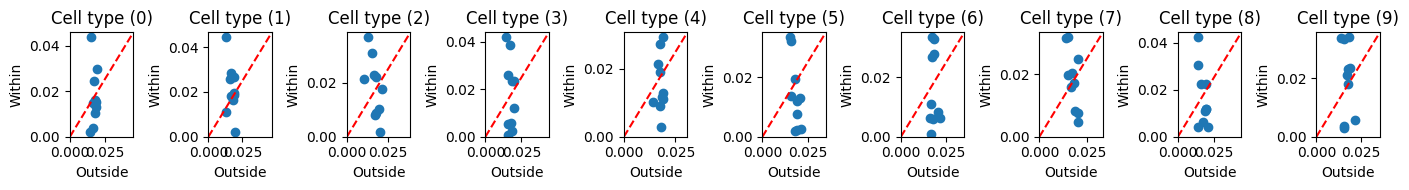

In [8]:
df_w4_ism = pd.DataFrame(w4_ism)
df_w4_ism['list_cell_codes'] = list_cell_codes
specificity, df_means_within_outside = specificity_score(df_w4_ism)
print(specificity)
specificity_plot(df_means_within_outside)